CODE VECTORIZATION

In [1]:

#import sys
import os
import numpy as np
import pandas as pd

class ClsEmbedding():
   """
    Creates an ClsEmbedding object. This object transforms all the code snippets into a dataframe.

    Attributes
    ----------
    data : dataframe
        dataframe is obtained from the csv file containing the file names. the path of the csv file is indicated.
    datafile: string
       the path to the folder containing the files.
    tokenizer: tokenizer
       it is obtained from RobertaTokenizer.from_pretrained(model_name)
    model: T5ForConditionalGeneration.from_pretrained(model_name)
       pre-trained model
    batch: int
        the number of samples per batch.
    Methods
    -------
    get_embedding()
        transforms all the code snippets into a dataframe
    get_matrix()
        obtain the matrix of embeddings
    """
   def __init__(self, data, datafile, tokenizer, model, batch):

     self.data = data
     self.datafile = datafile

     self.tokenizer = tokenizer
     self.model = model.to(device)
     self.stepbatch = 0
     self.batch = batch
     self.matrix_data= pd.DataFrame(columns=['Matrix'])

   #Embedding
   def get_embedding(self):

     X_data = self.data.iloc[:, 0].tolist()
     ID_data = self.data.index.tolist()
     if len(X_data)%self.batch == 0:
       self.stepbatch = int((len(X_data)/self.batch))
     else:
       self.stepbatch = int((len(X_data)//self.batch)) + 1
     for i in range(int(self.stepbatch)):
      batch_samples =[]
      generator_ = []
      generator_index = []
      if len(X_data) - i*(self.batch + 1) <= self.batch:
        batch_samples = X_data[i*(self.batch + 1): len(X_data)]
        batch_ID = ID_data[i*(self.batch + 1): len(X_data)]
      else:
        batch_samples = X_data[i*(self.batch + 1):i*(self.batch + 1) + self.batch]
        batch_ID = ID_data[i*(self.batch + 1):i*(self.batch + 1) + self.batch]

      for k, batchs in enumerate(batch_samples):  # Loop with step of 'batch'
        if os.path.exists(self.datafile + "/" + batchs):
          with open(self.datafile + "/" + batchs, 'rb') as file:
            detected_encoding = chardet.detect(file.read())['encoding']
          with open(self.datafile + "/" + batchs, "r", encoding= detected_encoding) as fichier:
            contenu = fichier.readlines()
            if contenu!=[]:
              inputs = self.tokenizer.encode_plus(contenu, padding='longest', truncation=True, return_tensors='pt')
              inputs = inputs.to(device)
              outputs = self.model(inputs.input_ids, attention_mask=inputs.attention_mask, decoder_input_ids = inputs['input_ids'], output_hidden_states=True )
              embedding = outputs.encoder_last_hidden_state
              embedding = embedding.to(device)
              mean = pt.mean(embedding, dim=(1,2))
              std = pt.std(embedding, dim=(1,2))
              normalized_embedding = (embedding - mean) / std
              normalized_embedding = normalized_embedding.to(device)
              reduced_normalized_embedding = pt.mean(normalized_embedding, dim=0).to(device)
              fused_normalized_embeddings = pt.mean(reduced_normalized_embedding, dim=0).to(device)
              x_normalized = (fused_normalized_embeddings - fused_normalized_embeddings.min()) / (fused_normalized_embeddings.max() - fused_normalized_embeddings.min())
              generator_.append(x_normalized.cpu().detach().numpy())
              generator_index.append(batch_ID[k])
        else:
          print("Fichier introuvable")

      if len(generator_index) == len(generator_):
        df = pd.DataFrame({'Identity': generator_index, 'Matrix': generator_})
        yield df

   def get_matrix(self):
    matrix_data = []
    matrix_index = []
    generator = self.get_embedding()
    for j, data_X in enumerate(generator):
      if j == 0:
        matrix_data = data_X.iloc[:, 1:]
        matrix_index = data_X.iloc[:, 0]
      else:
        if j > 0:
          matrix_data = pd.concat([matrix_data, data_X.iloc[:, 1:]], axis = 0)
          matrix_index = pd.concat([matrix_index, data_X.iloc[:, 0]], axis = 0)
    flattened_data = matrix_data.iloc[:, 0].apply(lambda x: x.flatten())
    new_matrix_data = pd.DataFrame(flattened_data.tolist(), index=matrix_index.tolist())
    return new_matrix_data



LOADING DATA AND EMBEDDING MODEL

In [2]:
import torch as pt
import gc
import chardet
from transformers import RobertaTokenizer, T5ForConditionalGeneration
import requests
import pandas as pd
from sklearn.utils import resample
#Setting device
if pt.cuda.is_available():
  device = "cuda"
  pt.cuda.empty_cache()
  # Enable GPU.
  pt.cuda.set_device(0)
else:
  device ="cpu"
gc.collect()
#Parameter
batch = 100
#embedding model
model_name = 'Salesforce/codet5-small'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def get_load_test (file_csv, file_java):
  # Nom du répertoire du dépôt
  repo_dir = '/content/Approche-hybride-poltergeist/'

  # Vérifier si le répertoire existe
  if os.path.isdir(repo_dir) == False:
    # Cloner le dépôt Github dans le répertoire actuel de Colab
    !git clone https://github.com/Maxime1969/Approche-hybride-poltergeist.git

  #loading data
  data_ = pd.read_csv('/content/Approche-hybride-poltergeist/' + file_csv, sep =',', index_col = "ID")
  data_ = resample(data_, replace = False, n_samples = len(data_), random_state=42)
  datafile = "/content/Approche-hybride-poltergeist/" + file_java
  embedding = ClsEmbedding(data_, datafile, tokenizer, model, batch)
  X_data = embedding.get_matrix()
  return X_data

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [3]:
from torch.utils.data import Dataset
import pandas as pd
class CodeDataset(Dataset):
    def __init__(self, dataframe):
        if not isinstance(dataframe, pd.DataFrame):
            raise TypeError("Input 'dataframe' must be a pandas DataFrame.")
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        code = self.data.iloc[idx].values
        return code

CHECK THE PARTITIONING OF DATA SET INTO TWO SUBSETS

Cloning into 'Approche-hybride-poltergeist'...
remote: Enumerating objects: 998, done.
remote: Counting objects: 100% (998/998), done.
remote: Compressing objects: 100% (700/700), done.
remote: Total 998 (delta 343), reused 901 (delta 294), pack-reused 0
Receiving objects: 100% (998/998), 1.90 MiB | 17.49 MiB/s, done.
Resolving deltas: 100% (343/343), done.


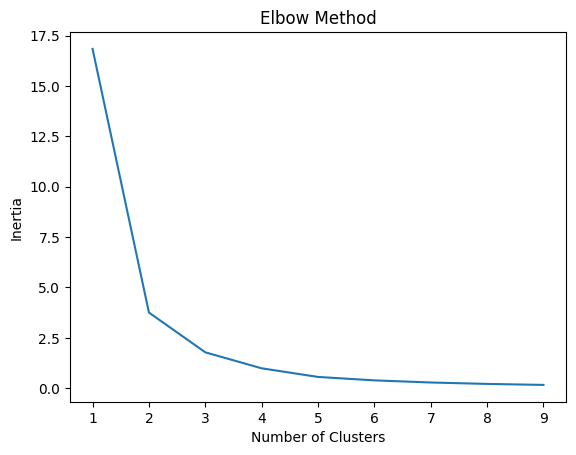

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
X_data = get_load_test("apache-ant.csv", "File_apache-ant-1.6.2")
inert = []
for i in range(1, 10):
   kmeans = KMeans(n_clusters=i, random_state=42, n_init= 10)
   # Train Model
   kmeans.fit(X_data)
   inert.append(kmeans.inertia_)

#Elbow method
plt.plot(range(1,10), inert)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

ISOLATION MODEL

313
ensemble_outliers [202400101, 202400107, 202400116, 202400117, 202400121, 202400125, 202400127, 202400134, 202400135, 202400136, 202400140, 202400143, 202400144, 202400145, 202400147, 202400148, 202400150, 202400151, 202400155, 202400158, 202400161, 202400162, 202400166, 202400167, 202400173, 202400178, 202400185, 202400191, 202400198, 202400199, 202400203, 202400206, 202400207, 202400208, 202400209, 202400215, 202400216, 202400226, 202400227, 202400231, 202400236, 202400239, 202400242, 202400243, 202400246, 202400247, 202400250, 202400251, 202400253, 202400258, 202400259, 202400260, 202400262, 202400264, 202400265, 202400270, 202400272, 202400276, 202400277, 202400280, 202400284, 202400288, 202400292, 202400295, 202400296, 202400297, 202400299, 202400300, 202400302, 202400306, 202400313, 202400314, 202400316, 202400317, 2024000, 2024003, 2024004, 2024005, 2024006, 2024007, 202400332, 202400335, 202400337, 202400339, 202400340, 202400342, 202400345, 202400364, 202400365, 202400367,

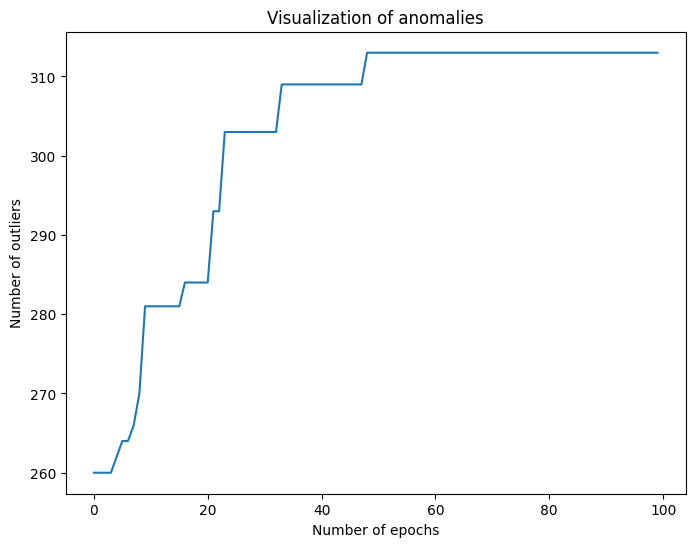

In [ ]:
from sklearn.ensemble import IsolationForest
alloutliers = []
myoutliers = []
epoch = 100
lsitepoch = []
Threshold = [0.04, 0.05, 0.07, 0.08, 0.1, 0.2]
# definie Isolation Forest model
for j in range(epoch):
 for threshold in Threshold:
  listoutliers = []
  for i in range(100):
    modelIF = IsolationForest(n_estimators= 100, max_samples=256, contamination = threshold, max_features = X_data.shape[1])
    modelIF.fit(X_data)
    X_data['anomaly']= modelIF.predict(X_data)
    outliers = [myindex for myindex in X_data.index if X_data.loc[myindex, 'anomaly'] == -1]
    listoutliers.extend(outliers)
    X_data= X_data.drop(columns=X_data.columns[-1])
  alloutliers.append(listoutliers)
 ens_outliers = {item for sublist in alloutliers for item in sublist}
 myoutliers.append((len(ens_outliers), list(ens_outliers)))
number_outliers, list_outliers = zip(*myoutliers)
Number_outliers =list(number_outliers)
List_outliers = list(list_outliers)
max_outliers = max(Number_outliers)
print(max_outliers)
ensemble_outliers = list({item for sublist in List_outliers for item in sublist if len(sublist) == max_outliers})
print(f"ensemble_outliers {ensemble_outliers}")
X_outliers = X_data.loc[ensemble_outliers]

# Trace des clusters
plt.figure(figsize=(8, 6))
plt.plot(range(epoch), number_outliers)
plt.xlabel('Number of epochs')
plt.ylabel('Number of outliers')
plt.title('Visualization of anomalies')
plt.show()


DEFINITION OF THE VAE MODEL

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Définir l'architecture du VAE
class ClsVAE(nn.Module):
    def __init__(self, input_dim, hiden_dim, latent_dim):
        super(ClsVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hiden_dim),
            #nn.ReLU(),
            nn.LeakyReLU(0.3),
            nn.Linear(hiden_dim, hiden_dim // 2),
            #nn.ReLU(),
            nn.LeakyReLU(0.3),
            nn.Linear(hiden_dim // 2, latent_dim * 2)  # Le double de latent_dim pour les moyennes et les log_variances
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hiden_dim // 2),
            #nn.ReLU(),
            nn.LeakyReLU(0.3),
            nn.Linear(hiden_dim//2, hiden_dim),
            #nn.ReLU(),
            nn.LeakyReLU(0.3),
            nn.Linear(hiden_dim, input_dim),
            nn.Sigmoid()  # Pour s'assurer que les valeurs reconstruites sont comprises entre 0 et 1
        )

    def reparameterize(self, mu, log_var):
        std = pt.exp(0.5 * log_var)
        eps = pt.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc_output = self.encoder(x)
        mu, log_var = enc_output[:, :self.latent_dim], enc_output[:, self.latent_dim:]
        z = self.reparameterize(mu, log_var)
        dec_output = self.decoder(z)
        return dec_output, mu, log_var, z

# Définir la fonction perte ELBO (Evidence Lower Bound)
def loss_function(recon_x, x, mu, log_var, beta):
    BCE = nn.functional.binary_cross_entropy(recon_x.float(), x.float(), reduction='sum')
    KLD = -0.5 * pt.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + beta*KLD

# Entraînement du VAE
def train_vae(vae, train_dataloader, optimizer, num_epochs, test_dataloader, beta):
    vae.train()
    losses_tain = []
    #losses_test = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs in train_dataloader:
            optimizer.zero_grad()
            recon_batch, mu, log_var, z = vae(inputs.float())
            loss = loss_function(recon_batch.float(), inputs.float(), mu, log_var, beta)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        losses_tain.append(epoch_loss)

        # Evaluate on test data
        test_loss = evaluate_vae(vae, test_dataloader, beta)
        #losses_test.append(test_loss)
    return losses_tain

def evaluate_vae(vae, test_dataloader, beta):
    vae.eval()
    total_loss = 0.0
    with pt.no_grad():
       for inputs in test_dataloader:
            recon_batch, mu, log_var, z = vae(inputs.float())
            loss = loss_function(recon_batch.float(), inputs.float(), mu, log_var, beta)
            total_loss += loss.item()

    return total_loss / len(test_dataloader.dataset)

def min_max_scaling(original_list):
    # Find the minimum and maximum values in the original list
    min_value = min(original_list)
    max_value = max(original_list)

    # Create a new empty list to store the normalized values
    normalized_list = []

    # Normalize each item in the original list
    for item in original_list:
        normalized_value = (item - min_value) / (max_value - min_value)
        normalized_list.append(normalized_value)

    return normalized_list
# Anomaly detection using VAE
def anomaly_detection(vae, X_anomalous, threshold, numbersample):
    vae.eval()
    with pt.no_grad():
      anomaly_indices = []
      reconstruction_prob_sum = 0
      for x in X_anomalous:
         reconstruction_prob_sum = 0
         _, mu_z, log_var_z, _ = vae(x.float())  # Forward pass through the encoder
         for _ in range(numbersample):
           z = vae.reparameterize(mu_z, log_var_z)
           recon_x = vae.decoder(z)  # Forward pass through the decoder
           reconstruction_prob = F.binary_cross_entropy(recon_x.float(), x.float(), reduction='sum')  # Calculate reconstruction probability
           reconstruction_prob_sum += reconstruction_prob.item()
         reconstruction_prob_avg = reconstruction_prob_sum / numbersample
         # Flag anomaly based on threshold
         #if reconstruction_prob_avg < threshold:
         anomaly_indices.append(reconstruction_prob_avg)
    normalized_list = min_max_scaling(anomaly_indices)
    return normalized_list

def plot_loss_curves(train_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Fonction Perte')
    #plt.plot(epochs, test_losses, label='Test Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Perte')
    plt.title(' Fonction perte')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour calculer la probabilité de reconstruction
def reconstruction_probability(x, encoder, decoder):
    mean, log_var = encoder(x)

    # Échantillonnage de z à partir de la distribution normale
    epsilon = pt.randn_like(mean)
    z = mean + pt.exp(0.5 * log_var) * epsilon

    # Reconstruction de x à partir de z
    reconstructed_x = decoder(z)

    # Calcul de la log-vraisemblance marginale
    log_likelihood = F.binary_cross_entropy(reconstructed_x, x, reduction='none').sum(dim=1)

    # Calcul de la probabilité de reconstruction
    reconstruction_prob = -0.5 * pt.sum(log_var + log_likelihood)

    return reconstruction_prob

Epoch [1/100], Loss: 306.8274
Epoch [2/100], Loss: 138.1948
Epoch [3/100], Loss: 104.0607
Epoch [4/100], Loss: 102.8869
Epoch [5/100], Loss: 97.3422
Epoch [6/100], Loss: 94.3197
Epoch [7/100], Loss: 93.4366
Epoch [8/100], Loss: 93.2709
Epoch [9/100], Loss: 92.9646
Epoch [10/100], Loss: 92.7574
Epoch [11/100], Loss: 92.6748
Epoch [12/100], Loss: 92.6394
Epoch [13/100], Loss: 92.7071
Epoch [14/100], Loss: 92.6935
Epoch [15/100], Loss: 92.5940
Epoch [16/100], Loss: 92.6009
Epoch [17/100], Loss: 92.5776
Epoch [18/100], Loss: 92.5629
Epoch [19/100], Loss: 92.6249
Epoch [20/100], Loss: 92.5757
Epoch [21/100], Loss: 92.5984
Epoch [22/100], Loss: 92.6413
Epoch [23/100], Loss: 92.5879
Epoch [24/100], Loss: 92.5690
Epoch [25/100], Loss: 92.5843
Epoch [26/100], Loss: 92.5880
Epoch [27/100], Loss: 92.5981
Epoch [28/100], Loss: 92.6005
Epoch [29/100], Loss: 92.5958
Epoch [30/100], Loss: 92.5051
Epoch [31/100], Loss: 92.6152
Epoch [32/100], Loss: 92.5205
Epoch [33/100], Loss: 92.5961
Epoch [34/100],

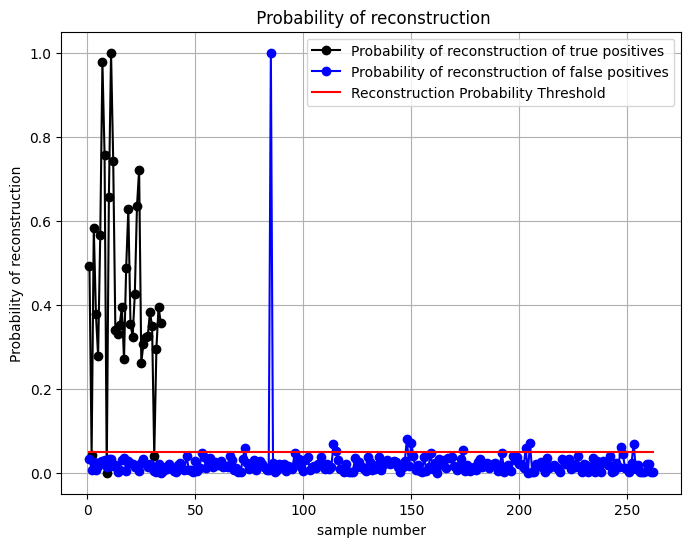

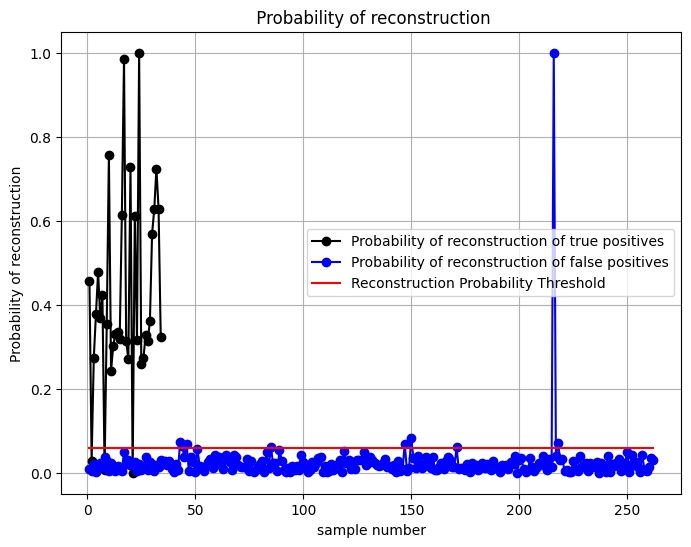

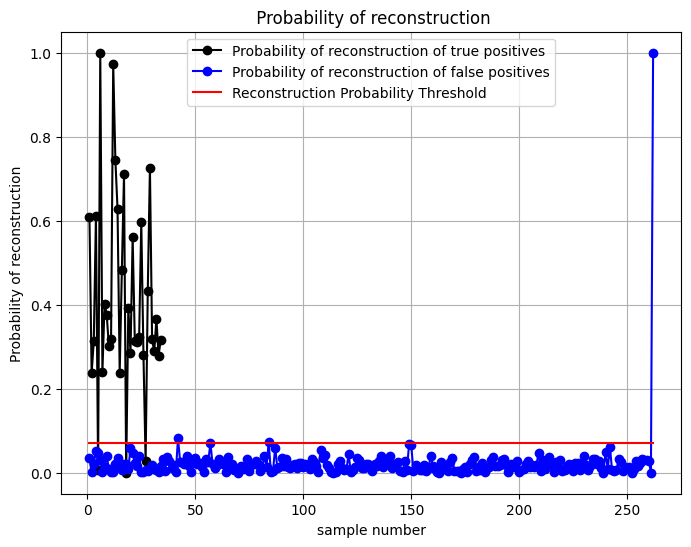

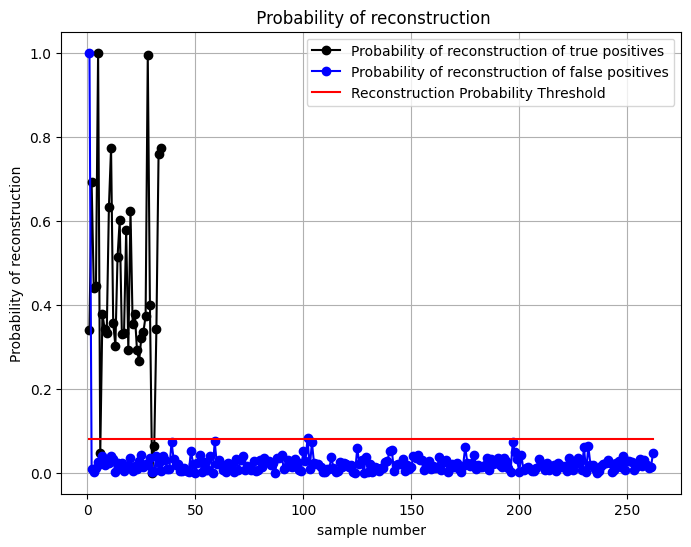

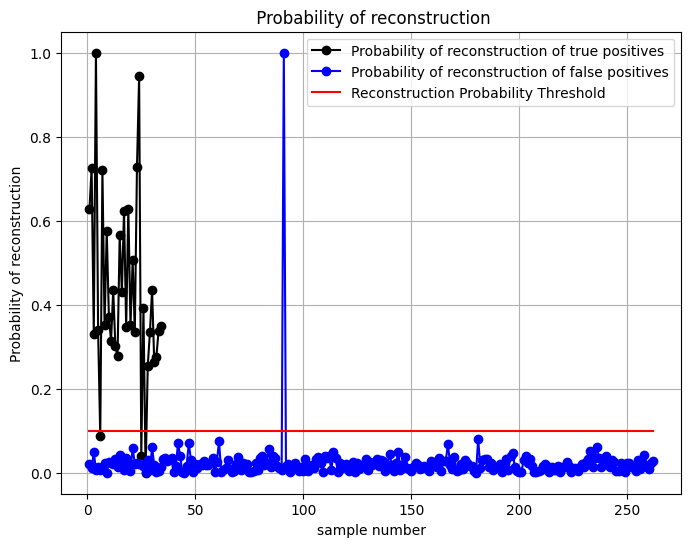

In [6]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim


#Parameters
batch_size = 100
hidden_dim = 500
latent_dim = 250  # Latent space dimension
lr = 1e-3
epochs = 100
beta = 4.0  # Parameter β

data_train, data_test = train_test_split(X_data, test_size=0.20, random_state=42)
datasetrain = CodeDataset(data_train)
X_dataloader_train = DataLoader(datasetrain, batch_size=batch_size, shuffle=True)
datasetest = CodeDataset(data_test)
X_dataloader_test = DataLoader(datasetest, batch_size=batch_size, shuffle=True)
# Initialiser le modèle et l'optimiseur
vae = ClsVAE(X_data.shape[1], hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# train VAE
train_losses = train_vae(vae, X_dataloader_train, optimizer, epochs, X_dataloader_test, beta)

#Loading true positive data
matrixpoltergeist = get_load_test("apache-ant-poltergeist.csv", "File_apache-ant-poltergeist")
datasetvalue = CodeDataset(matrixpoltergeist)
X_dataloader_evalue = DataLoader(datasetvalue, batch_size=1, shuffle=True)

#Loading true negative data
matrixfaux  = get_load_test("apache-ant-falsepositifs.csv", "File_apache-ant-falsepositifs")
datasetvaluefaux = CodeDataset(matrixfaux)
X_dataloaderfaux_evalue = DataLoader(datasetvaluefaux, batch_size=1, shuffle=True)

#detection validation
threshold = [0.05, 0.06, 0.07, 0.08, 0.1]
numbersample = 10
for seuil in threshold:
  anomaly_indices = anomaly_detection(vae, X_anomalous = X_dataloader_evalue, threshold = seuil, numbersample = numbersample)
  anomaly_faux = anomaly_detection(vae, X_anomalous = X_dataloaderfaux_evalue, threshold = seuil, numbersample = numbersample)
  sampletrue = range(1, len( X_dataloader_evalue.dataset) + 1)
  samplefalse = range(1, len( X_dataloaderfaux_evalue.dataset) + 1)
  sample = range(1, numbersample + 2)
  plt.figure(figsize=(8, 6))
  plt.plot(sampletrue, anomaly_indices, label='Probability of reconstruction of true positives',  marker='o', color='black')
  plt.plot(samplefalse, anomaly_faux, label='Probability of reconstruction of false positives', marker='o', color='blue')
  plt.plot(samplefalse, [seuil for _ in samplefalse]  , label='Reconstruction Probability Threshold', color='red')
  plt.xlabel('sample number')
  plt.ylabel('Probability of reconstruction')
  plt.title(' Probability of reconstruction')
  plt.legend()
  plt.grid(True)
  plt.show()